# Series de tiempo Bog-Gir

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import fbprophet as prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Funciones

In [2]:
def ploteaMAsa(sr,tit=''):
    # Función que grafica una serie junto sus medias moviles de semana y año
    src = sr[sr>0]
    plt.plot(src, label='trafico')
    plt.plot(src.rolling(window=7).mean(), label='Media movil - Semana', color='orange')
    plt.plot(src.rolling(window=365).mean(), label='Media movil - Año', color='magenta')
    plt.legend(loc='upper left')
    plt.title(tit)
    fig = plt.gcf()
    fig.set_size_inches(15,5)
    plt.show()

### Carga datos

In [3]:
#Trafico
datos = pd.read_csv('../Entradas/BGDiario.csv')

In [4]:
#Festivos
festivos = pd.read_csv('../Entradas/festivos08-22.csv')
festivos['fecha'] = festivos.apply(lambda row: pd.Timestamp(year=row['Ano'],month=row['Mes'],day=row['Dia']),axis=1)
festivos.drop(['Ano','Mes','Dia'],inplace=True,axis=1)
festivos.columns = ['holiday','ds']

In [5]:
#Festivos excluyendo los festivos de la cuarentena
festivos_sinCov = festivos[(festivos['ds']<pd.Timestamp(year=2020,month=3,day=20))|\
         (festivos['ds'] > pd.Timestamp(year=2020,month=8,day=31))].copy()

In [25]:
festivos

,holiday,ds
0,AN,2008-01-01
1,RMV,2008-01-04
2,RMS,2008-01-05
3,RMD,2008-01-06
4,RM,2008-01-07
...,...,...
782,ICV,2022-11-11
783,ICS,2022-11-12
784,ICD,2022-11-13
785,IC,2022-11-14


### Procesa y explora datos

In [6]:
#Crea columna de fecha
datos['Fecha'] = datos.apply(lambda row: pd.Timestamp(year=row['Ano'],month=row['Mes'],day=row['Dia']),axis=1)

In [7]:
#Elimina columnas Ano, Mes y Dia
datos.drop(['Ano','Mes','Dia'],inplace=True,axis=1)

In [8]:
#Establece la fecha como indice
datos.set_index('Fecha',inplace=True)

##### Exploración

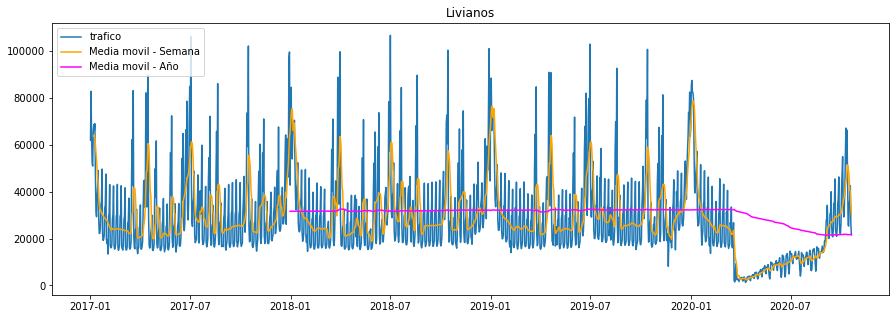

In [9]:
ploteaMAsa(datos['Liv'],'Livianos')

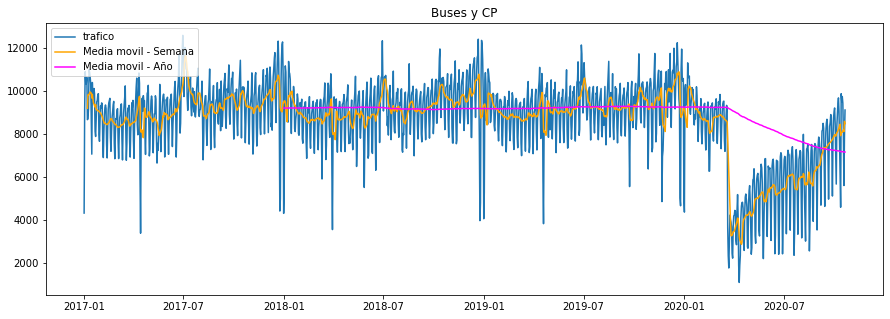

In [10]:
ploteaMAsa(datos['CP'],'Buses y CP')

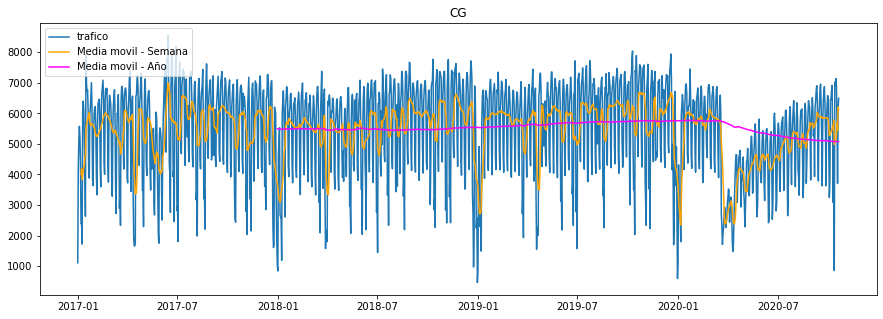

In [11]:
ploteaMAsa(datos['CG'],'CG')

### Changepoints

In [12]:
chg = [pd.Timestamp(day = 1, month = x[1], year = x[0]) for x in ([(i,1)for i in range(2018,2020)])]

In [13]:
chg_cg = chg + [pd.Timestamp(day = x[0], month = x[1], year = 2020) for x in \
        [(15,3),(18,3),(20,3),(22,3),(25,3),(30,3),(15,5),(15,7),(25,8),(30,8),(1,9),
         (3,9)]]

In [14]:
chg += [pd.Timestamp(day = x[0], month = x[1], year = 2020) for x in \
        [(15,3),(18,3),(20,3),(22,3),(25,3),(30,3),(15,5),(15,7),(25,8),(28,8),(30,8),(1,9),
         (3,9),(5,9),(15,9),(25,9),(5,10)]]

### Prepara datos para el modelo

In [15]:
#Crea copia del df de trafico
datosEntrada = datos.copy()
datosEntrada.reset_index(inplace=True)

In [16]:
#Genera columnas que indican las fechas de cuarentena
datosEntrada['cuarentena'] = datosEntrada['Fecha'].apply(lambda x: False if x <= pd.Timestamp(year=2020,month=3,day=20)\
                                                    or x > pd.Timestamp(year=2020,month=8,day=31) else True)
datosEntrada['pre_covid'] = datosEntrada['Fecha'].apply(lambda x: True if x <= pd.Timestamp(year=2020,month=3,day=20)\
                                                     else False)
datosEntrada['pos_cuarentena'] = datosEntrada['Fecha'].apply(lambda x: True if x >= pd.Timestamp(year=2020,month=9,day=1)\
                                                     else False)

### Modelos iniciales

##### Livianos

In [17]:
k= 'Liv'

In [18]:
ent = datosEntrada[['Fecha',k,'pre_covid','cuarentena','pos_cuarentena']].copy()
ent.columns=['ds','y','pre_covid','cuarentena','pos_cuarentena']

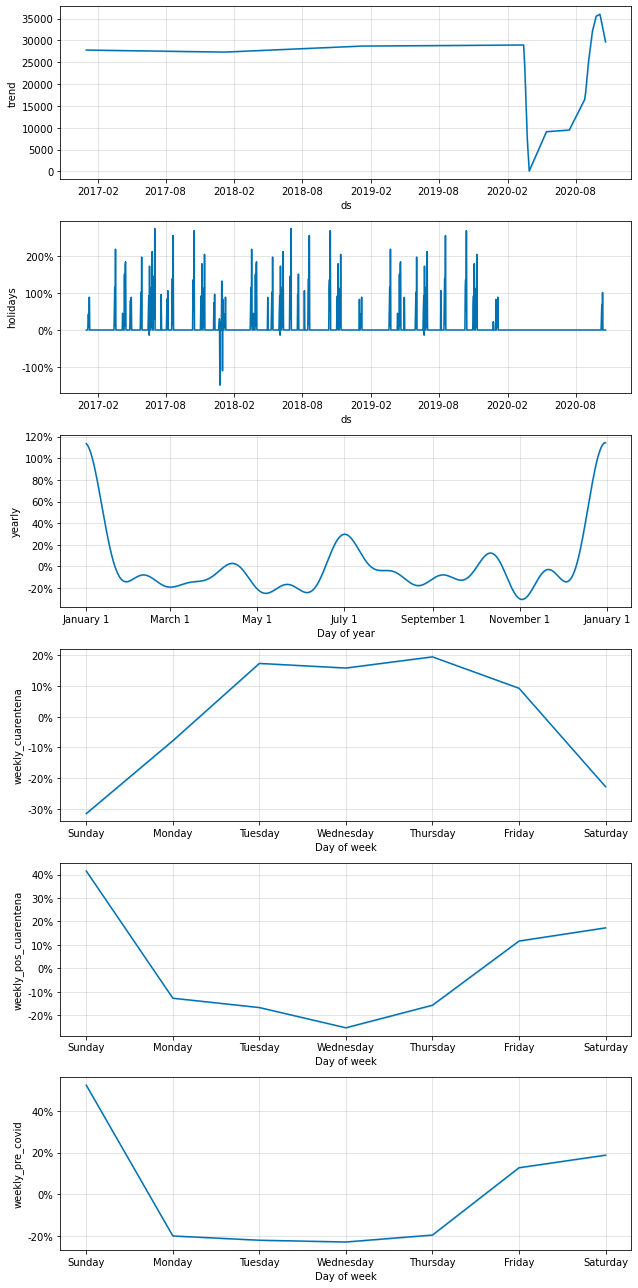

In [24]:
#Define modelo
model = prophet.Prophet(interval_width=0.95, yearly_seasonality=True, holidays=festivos_sinCov, 
                        daily_seasonality=False, weekly_seasonality=False, seasonality_mode='multiplicative',
                        changepoints=chg, changepoint_prior_scale=50)
#Estacionalidades específicas por periodo
model.add_seasonality(name='weekly_pre_covid', period=7, fourier_order=3, condition_name='pre_covid')
model.add_seasonality(name='weekly_cuarentena', period=7, fourier_order=3, condition_name='cuarentena')
model.add_seasonality(name='weekly_pos_cuarentena', period=7, fourier_order=3, condition_name='pos_cuarentena')
#Entrena el modelo
model.fit(ent)
#Plotea resultados
ax = model.plot_components(model.predict())

In [20]:
#Crea dataframe futuro para proyecciones con los mismos identificadores del covid que el dataset
# de entrada
future = pd.DataFrame()
future['ds'] = pd.date_range(start=ent['ds'].min(),end=ent['ds'].max(),freq='D')
future['cuarentena'] = future['ds'].apply(lambda x: False if x <= pd.Timestamp(year=2020,month=3,day=20)\
                                                    or x > pd.Timestamp(year=2020,month=8,day=31) else True)
future['pre_covid'] = future['ds'].apply(lambda x: True if x <= pd.Timestamp(year=2020,month=3,day=20)\
                                                     else False)
future['pos_cuarentena'] = future['ds'].apply(lambda x: True if x >= pd.Timestamp(year=2020,month=9,day=1)\
                                                     else False)

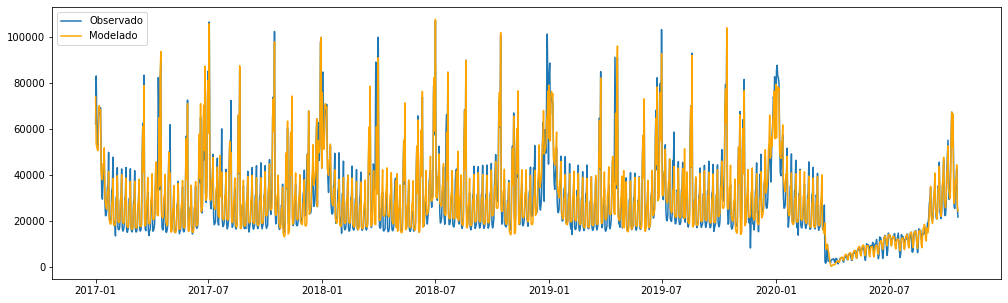

In [21]:
#Realiza Predicciones
forecast = model.predict(future)
#Plotea modelado vs proyectado
fig = plt.gcf()
fig.set_size_inches(17,5)
plt.plot(datosEntrada['Fecha'],datosEntrada[k],label='Observado')
plt.plot(forecast['ds'],forecast['yhat'],label='Modelado', color='orange')
plt.legend(loc='upper left')

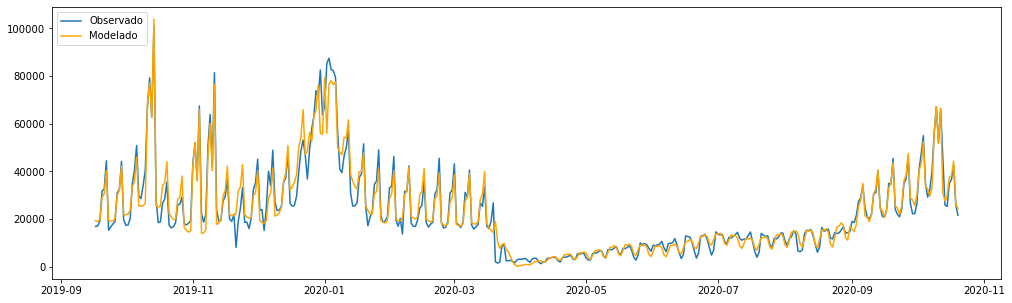

In [22]:
#Plotea modelado vs proyectado a partir de mayo 2019
fig = plt.gcf()
fig.set_size_inches(17,5)
plt.plot(datosEntrada['Fecha'].iloc[-400:],datosEntrada[k].iloc[-400:], 
         label='Observado')
plt.plot(forecast['ds'].iloc[-400:],forecast['yhat'].iloc[-400:],
         label='Modelado', color='orange')
plt.legend(loc='upper left')

##### Buses y CP

In [23]:
k= 'CP'

In [24]:
ent = datosEntrada[['Fecha',k,'pre_covid','cuarentena','pos_cuarentena']].copy()
ent.columns=['ds','y','pre_covid','cuarentena','pos_cuarentena']

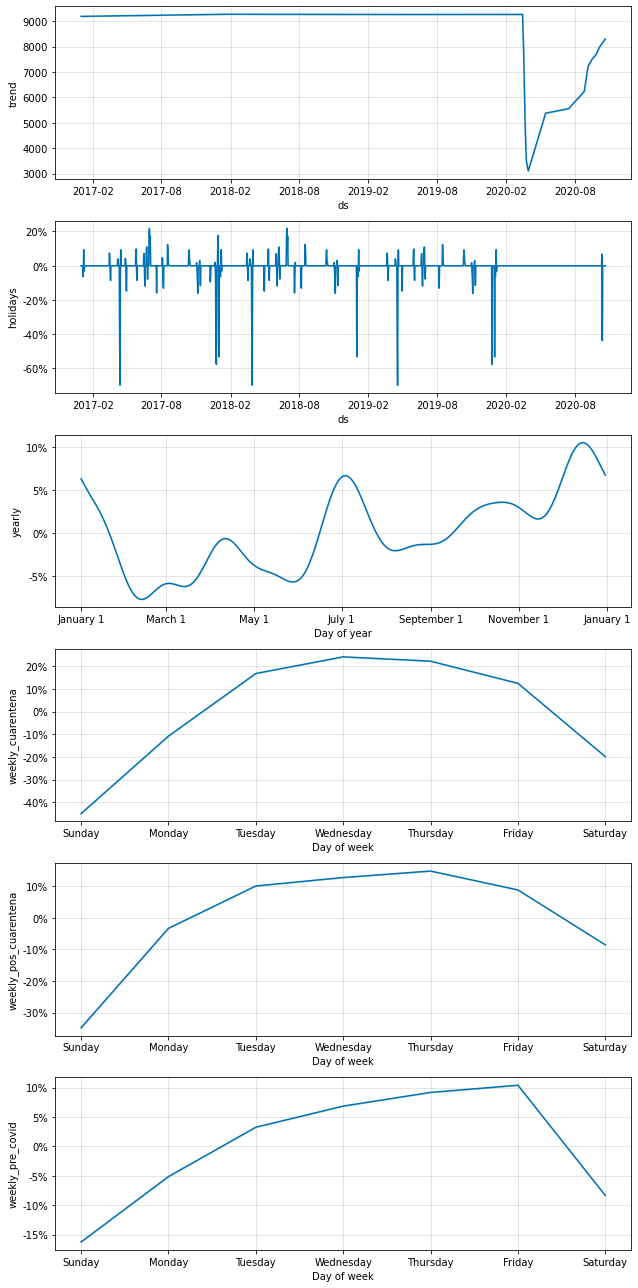

In [25]:
#Define modelo
model = prophet.Prophet(interval_width=0.95, yearly_seasonality=True, holidays=festivos_sinCov, 
                        daily_seasonality=False, weekly_seasonality=False, seasonality_mode='multiplicative',
                        changepoints=chg, changepoint_prior_scale=50)
#Estacionalidades específicas por periodo
model.add_seasonality(name='weekly_pre_covid', period=7, fourier_order=3, condition_name='pre_covid')
model.add_seasonality(name='weekly_cuarentena', period=7, fourier_order=3, condition_name='cuarentena')
model.add_seasonality(name='weekly_pos_cuarentena', period=7, fourier_order=3, condition_name='pos_cuarentena')
#Entrena el modelo
model.fit(ent)
#Plotea resultados
pred = model.predict()
ax = model.plot_components(pred)

In [26]:
#Crea dataframe futuro para proyecciones con los mismos identificadores del covid que el dataset
# de entrada
future = pd.DataFrame()
future['ds'] = pd.date_range(start=ent['ds'].min(),end=ent['ds'].max(),freq='D')
future['cuarentena'] = future['ds'].apply(lambda x: False if x <= pd.Timestamp(year=2020,month=3,day=20)\
                                                    or x > pd.Timestamp(year=2020,month=8,day=31) else True)
future['pre_covid'] = future['ds'].apply(lambda x: True if x <= pd.Timestamp(year=2020,month=3,day=20)\
                                                     else False)
future['pos_cuarentena'] = future['ds'].apply(lambda x: True if x >= pd.Timestamp(year=2020,month=9,day=1)\
                                                     else False)

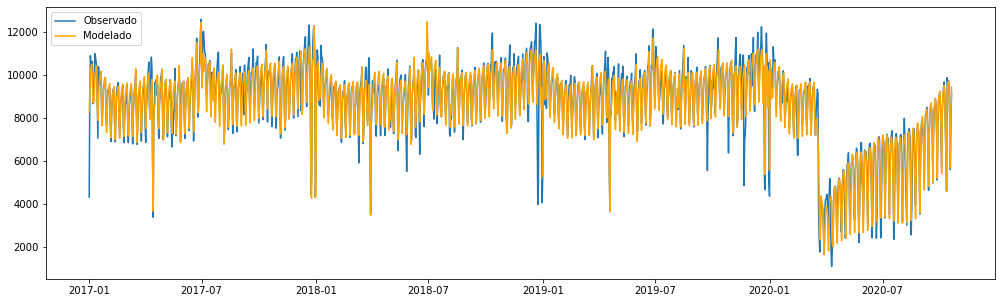

In [27]:
#Realiza Predicciones
forecast = model.predict(future)
#Plotea modelado vs proyectado
fig = plt.gcf()
fig.set_size_inches(17,5)
plt.plot(datosEntrada['Fecha'],datosEntrada[k],label='Observado')
plt.plot(forecast['ds'],forecast['yhat'],label='Modelado', color='orange')
plt.legend(loc='upper left')

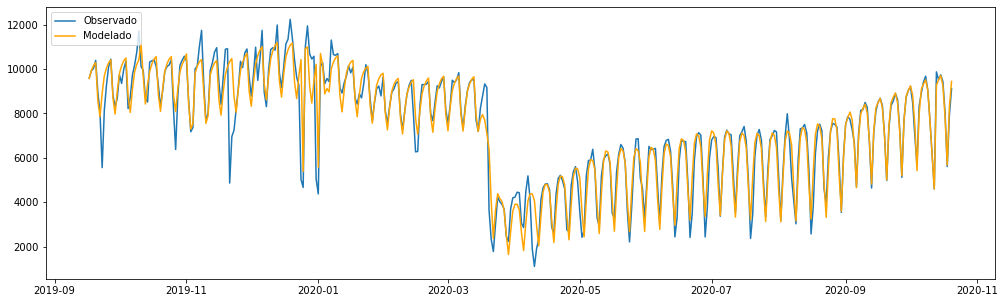

In [28]:
#Plotea modelado vs proyectado a partir de mayo 2019
fig = plt.gcf()
fig.set_size_inches(17,5)
plt.plot(datosEntrada['Fecha'].iloc[-400:],datosEntrada[k].iloc[-400:], 
         label='Observado')
plt.plot(forecast['ds'].iloc[-400:],forecast['yhat'].iloc[-400:],
         label='Modelado', color='orange')
plt.legend(loc='upper left')

##### CG

In [29]:
k = 'CG'

In [30]:
ent = datosEntrada[['Fecha',k,'pre_covid','cuarentena','pos_cuarentena']].copy()
ent.columns=['ds','y','pre_covid','cuarentena','pos_cuarentena']

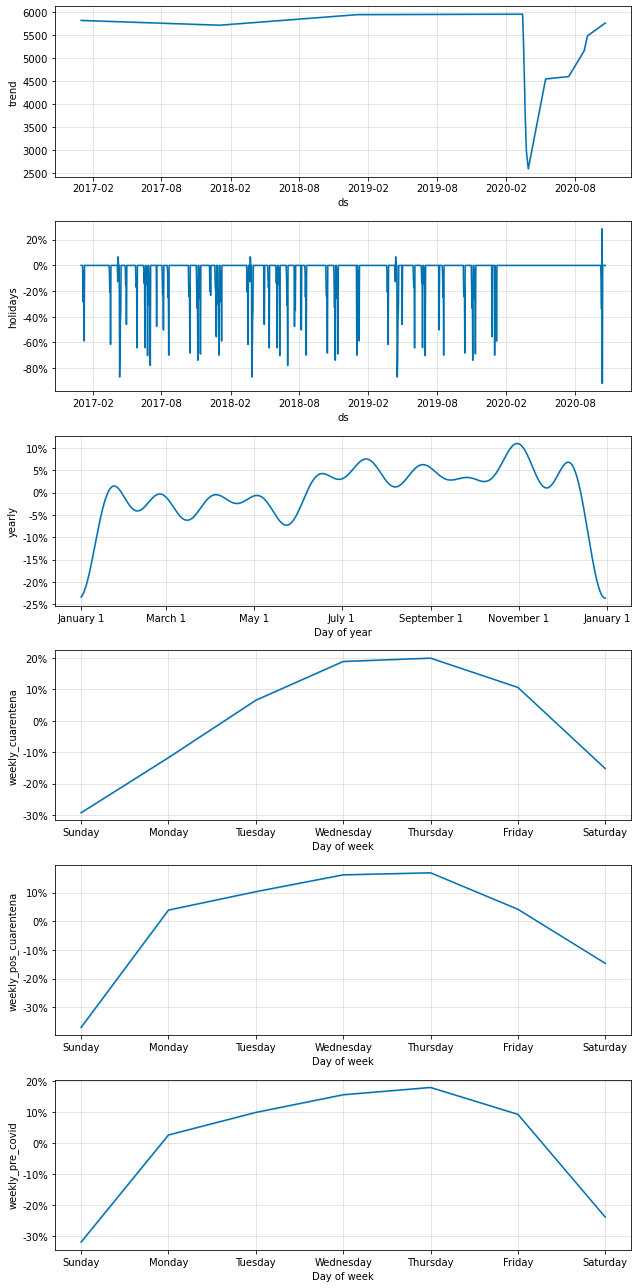

In [31]:
#Define modelo
model = prophet.Prophet(interval_width=0.95, yearly_seasonality=True, holidays=festivos_sinCov, 
                        daily_seasonality=False, weekly_seasonality=False, seasonality_mode='multiplicative',
                        changepoints=chg_cg, changepoint_prior_scale=50)
#Estacionalidades específicas por periodo
model.add_seasonality(name='weekly_pre_covid', period=7, fourier_order=3, condition_name='pre_covid')
model.add_seasonality(name='weekly_cuarentena', period=7, fourier_order=3, condition_name='cuarentena')
model.add_seasonality(name='weekly_pos_cuarentena', period=7, fourier_order=3, condition_name='pos_cuarentena')
#Entrena el modelo
model.fit(ent)
#Plotea resultados
ax = model.plot_components(model.predict())

In [32]:
#Crea dataframe futuro para proyecciones con los mismos identificadores del covid que el dataset
# de entrada
future = pd.DataFrame()
future['ds'] = pd.date_range(start=ent['ds'].min(),end=ent['ds'].max(),freq='D')
future['cuarentena'] = future['ds'].apply(lambda x: False if x <= pd.Timestamp(year=2020,month=3,day=20)\
                                                    or x > pd.Timestamp(year=2020,month=8,day=31) else True)
future['pre_covid'] = future['ds'].apply(lambda x: True if x <= pd.Timestamp(year=2020,month=3,day=20)\
                                                     else False)
future['pos_cuarentena'] = future['ds'].apply(lambda x: True if x >= pd.Timestamp(year=2020,month=9,day=1)\
                                                     else False)

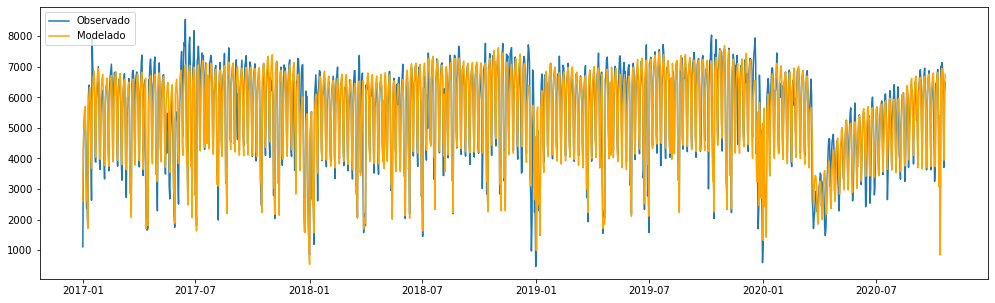

In [33]:
#Realiza Predicciones
forecast = model.predict(future)
#Plotea modelado vs proyectado
fig = plt.gcf()
fig.set_size_inches(17,5)
plt.plot(datosEntrada['Fecha'],datosEntrada[k],label='Observado')
plt.plot(forecast['ds'],forecast['yhat'],label='Modelado', color='orange')
plt.legend(loc='upper left')

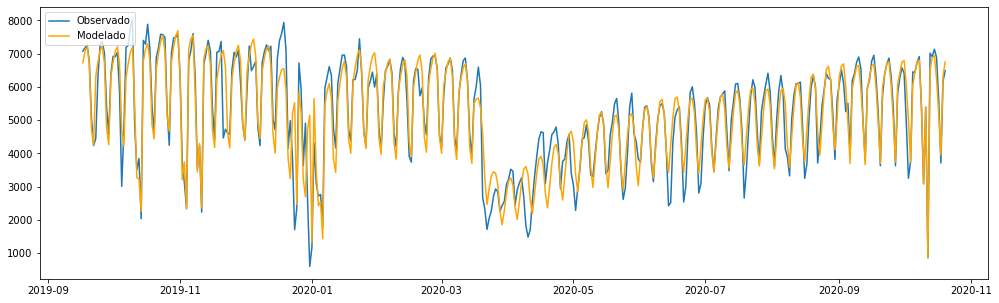

In [34]:
#Plotea modelado vs proyectado a partir de mayo 2019
fig = plt.gcf()
fig.set_size_inches(17,5)
plt.plot(datosEntrada['Fecha'].iloc[-400:],datosEntrada[k].iloc[-400:], 
         label='Observado')
plt.plot(forecast['ds'].iloc[-400:],forecast['yhat'].iloc[-400:],
         label='Modelado', color='orange')
plt.legend(loc='upper left')

A partir de estos modelos inciales se determinó que para livianos y camiones grandesque las estacionalidades semanales antes y después de la cuarentana son similares y se consideran como una sola.

### Validación cruzada

In [39]:
datosEntrada_train = datosEntrada[datosEntrada['Fecha']>pd.Timestamp(year=2017,month=7,day=1)]

In [40]:
datosEntrada_dev = datosEntrada[(datosEntrada['Fecha']>pd.Timestamp(year=2017,month=3,day=31))&\
                                (datosEntrada['Fecha']<=pd.Timestamp(year=2017,month=7,day=1))]

In [41]:
datosEntrada_test = datosEntrada[datosEntrada['Fecha']<=pd.Timestamp(year=2017,month=3,day=31)]

#### Livianos

In [79]:
k = 'Liv'

In [80]:
ent = datosEntrada_train[['Fecha',k,'cuarentena']].copy()
ent.columns=['ds','y','covid']
ent['no_covid'] = ~ent['covid']

In [81]:
for i in range(100):
    scales = 10**(5*np.random.rand(3)-2.5)
    #Define modelo
    model = prophet.Prophet(interval_width=0.95, yearly_seasonality=True, holidays=festivos_sinCov, 
                            daily_seasonality=False, weekly_seasonality=False, seasonality_mode='multiplicative',
                            changepoints=chg, changepoint_prior_scale=scales[0],seasonality_prior_scale=scales[1],
                            holidays_prior_scale=scales[2])
    #Estacionalidades específicas por periodo
    model.add_seasonality(name='weekly_no_covid', period=7, fourier_order=3, condition_name='no_covid')
    model.add_seasonality(name='weekly_covid', period=7, fourier_order=3, condition_name='covid')
    #Entrena el modelo
    model.fit(ent)
    pred = model.predict()
    #Crea dataframe futuro para proyecciones con los mismos identificadores del tcovid que el dataset
    # de entrada
    future = pd.DataFrame()
    future['ds'] = pd.date_range(start=pd.Timestamp(year=2017,month=1,day=1),end=ent['ds'].max(),freq='D')
    future['covid'] = future['ds'].apply(lambda x: False if x <= pd.Timestamp(year=2020,month=3,day=20)\
                                                        or x > pd.Timestamp(year=2020,month=8,day=31) else True)
    future['no_covid'] = ~future['covid']
    
    
    #Proyeccion y division de esta en conjuntos de entrenamiento, validacion y testeo
    forecast = model.predict(future)
    forecast_train = forecast[forecast['ds']>pd.Timestamp(year=2017,month=7,day=1)]
    forecast_dev = forecast[(forecast['ds']>pd.Timestamp(year=2017,month=3,day=31))&\
                                (forecast['ds']<=pd.Timestamp(year=2017,month=7,day=1))]
    forecast_test = forecast[forecast['ds']<=pd.Timestamp(year=2017,month=3,day=31)]
    #Estadisticos de bondad
    er_dev = np.sqrt(mean_squared_error(forecast_dev['yhat'],datosEntrada_dev[k]))
    er_train = np.sqrt(mean_squared_error(forecast_train['yhat'],datosEntrada_train[k]))
    er_test = np.sqrt(mean_squared_error(forecast_test['yhat'],datosEntrada_test[k]))
    r2_train = r2_score(forecast_train['yhat'],datosEntrada_train[k])
    r2_dev = r2_score(forecast_dev['yhat'],datosEntrada_dev[k])
    r2_test = r2_score(forecast_test['yhat'],datosEntrada_test[k])
    me_train = mean_absolute_error(forecast_train['yhat'],datosEntrada_train[k])
    me_dev = mean_absolute_error(forecast_dev['yhat'],datosEntrada_dev[k])
    me_test = mean_absolute_error(forecast_test['yhat'],datosEntrada_test[k])
    
    if i == 0:
        mini = er_dev+er_train
        res = pd.DataFrame(columns=['train','dev','test'])
        res.loc['rmse'] = [er_train,er_dev,er_test]
        res.loc['r2'] = [r2_train,r2_dev,r2_test]
        res.loc['me'] = [me_train,me_dev,me_test]
        scs = scales
        print('---------%i---------'%i)
        print('CH      SE      HO')
        print(scales)
        print(res)
    if mini > er_dev+er_train:
        mini = er_dev+er_train
        res.loc['rmse'] = [er_train,er_dev,er_test]
        res.loc['r2'] = [r2_train,r2_dev,r2_test]
        res.loc['me'] = [me_train,me_dev,me_test]
        scs = scales
        print('---------%i---------'%i)
        print('CH      SE      HO')
        print(scales)
        print(res)
        future = pd.DataFrame()
        future['ds'] = pd.date_range(start=pd.Timestamp(year=2017,month=1,day=1),
                                     end=pd.Timestamp(year=2022,month=12,day=31),freq='D')
        future['covid'] = future['ds'].apply(lambda x: False if x <= pd.Timestamp(year=2020,month=3,day=20)\
                                                            or x > pd.Timestamp(year=2020,month=8,day=31) else True)
        future['no_covid'] = ~future['covid']
        #Proyeccion y division de esta en conjuntos de entrenamiento, validacion y testeo
        forecast = model.predict(future)
        forecast.to_csv('../Salida/livianos.csv')
    

---------0---------
CH      SE      HO
[ 8.38404091 24.75599681  6.08312061]
            train          dev         test
rmse  5668.798422  8839.758485  5071.180803
r2       0.893375     0.779707     0.889590
me    3274.565069  4413.905875  3442.819326
---------4---------
CH      SE      HO
[ 11.79269727  27.75137267 105.37028012]
            train          dev         test
rmse  5664.663584  8841.129108  5077.916680
r2       0.893670     0.779828     0.889450
me    3266.491542  4419.494019  3448.594321
---------9---------
CH      SE      HO
[ 17.87182989   0.38504551 307.61269502]
            train          dev         test
rmse  5657.496300  8837.660844  5097.051798
r2       0.893898     0.779306     0.888227
me    3260.699296  4410.726057  3469.871170
---------27---------
CH      SE      HO
[11.47678161  0.04360492 11.65923019]
            train          dev         test
rmse  5703.147672  8775.668768  5234.233745
r2       0.888806     0.774390     0.875051
me    3351.918600  4473.4

#### Buses y CP

In [88]:
k = 'CP'

In [89]:
ent = datosEntrada[['Fecha',k,'pre_covid','cuarentena','pos_cuarentena']].copy()
ent.columns=['ds','y','pre_covid','cuarentena','pos_cuarentena']

In [84]:
for i in range(100):
    scales = 10**(5*np.random.rand(3)-2.5)
    #Define modelo
    model = prophet.Prophet(interval_width=0.95, yearly_seasonality=True, holidays=festivos_sinCov, 
                            daily_seasonality=False, weekly_seasonality=False, seasonality_mode='multiplicative',
                            changepoints=chg, changepoint_prior_scale=scales[0],seasonality_prior_scale=scales[1],
                            holidays_prior_scale=scales[2])
    #Estacionalidades específicas por periodo
    model.add_seasonality(name='weekly_pre_covid', period=7, fourier_order=3, condition_name='pre_covid')
    model.add_seasonality(name='weekly_cuarentena', period=7, fourier_order=3, condition_name='cuarentena')
    model.add_seasonality(name='weekly_pos_cuarentena', period=7, fourier_order=3, condition_name='pos_cuarentena')
    #Entrena el modelo
    model.fit(ent)
    pred = model.predict()
    #Crea dataframe futuro para proyecciones con los mismos identificadores del covid que el dataset
    # de entrada
    future = pd.DataFrame()
    future['ds'] = pd.date_range(start=ent['ds'].min(),end=ent['ds'].max(),freq='D')
    future['cuarentena'] = future['ds'].apply(lambda x: False if x <= pd.Timestamp(year=2020,month=3,day=20)\
                                                        or x > pd.Timestamp(year=2020,month=8,day=31) else True)
    future['pre_covid'] = future['ds'].apply(lambda x: True if x <= pd.Timestamp(year=2020,month=3,day=20)\
                                                         else False)
    future['pos_cuarentena'] = future['ds'].apply(lambda x: True if x >= pd.Timestamp(year=2020,month=9,day=1)\
                                                     else False)
    
    #Proyeccion y division de esta en conjuntos de entrenamiento, validacion y testeo
    forecast = model.predict(future)
    forecast_train = forecast[forecast['ds']>pd.Timestamp(year=2017,month=7,day=1)]
    forecast_dev = forecast[(forecast['ds']>pd.Timestamp(year=2017,month=3,day=31))&\
                                (forecast['ds']<=pd.Timestamp(year=2017,month=7,day=1))]
    forecast_test = forecast[forecast['ds']<=pd.Timestamp(year=2017,month=3,day=31)]
    #Estadisticos de bondad
    er_dev = np.sqrt(mean_squared_error(forecast_dev['yhat'],datosEntrada_dev[k]))
    er_train = np.sqrt(mean_squared_error(forecast_train['yhat'],datosEntrada_train[k]))
    er_test = np.sqrt(mean_squared_error(forecast_test['yhat'],datosEntrada_test[k]))
    r2_train = r2_score(forecast_train['yhat'],datosEntrada_train[k])
    r2_dev = r2_score(forecast_dev['yhat'],datosEntrada_dev[k])
    r2_test = r2_score(forecast_test['yhat'],datosEntrada_test[k])
    me_train = mean_absolute_error(forecast_train['yhat'],datosEntrada_train[k])
    me_dev = mean_absolute_error(forecast_dev['yhat'],datosEntrada_dev[k])
    me_test = mean_absolute_error(forecast_test['yhat'],datosEntrada_test[k])
    
    if i == 0:
        mini = er_dev+er_train
        res = pd.DataFrame(columns=['train','dev','test'])
        res.loc['rmse'] = [er_train,er_dev,er_test]
        res.loc['r2'] = [r2_train,r2_dev,r2_test]
        res.loc['me'] = [me_train,me_dev,me_test]
        scs = scales
        print('---------%i---------'%i)
        print('CH      SE      HO')
        print(scales)
        print(res)
    if mini > er_dev+er_train:
        mini = er_dev+er_train
        res.loc['rmse'] = [er_train,er_dev,er_test]
        res.loc['r2'] = [r2_train,r2_dev,r2_test]
        res.loc['me'] = [me_train,me_dev,me_test]
        scs = scales
        print('---------%i---------'%i)
        print('CH      SE      HO')
        print(scales)
        print(res)
        future = pd.DataFrame()
        future['ds'] = pd.date_range(start=pd.Timestamp(year=2017,month=1,day=1),
                                     end=pd.Timestamp(year=2022,month=12,day=31),freq='D')
        future['cuarentena'] = future['ds'].apply(lambda x: False if x <= pd.Timestamp(year=2020,month=3,day=20)\
                                                            or x > pd.Timestamp(year=2020,month=8,day=31) else True)
        future['pre_covid'] = future['ds'].apply(lambda x: True if x <= pd.Timestamp(year=2020,month=3,day=20)\
                                                             else False)
        future['pos_cuarentena'] = future['ds'].apply(lambda x: True if x >= pd.Timestamp(year=2020,month=9,day=1)\
                                                         else False)
        #Proyeccion y division de esta en conjuntos de entrenamiento, validacion y testeo
        forecast = model.predict(future)
        forecast.to_csv('../Salida/cp.csv')
    

---------0---------
CH      SE      HO
[2.13290544 7.96565078 7.47401762]
           train         dev        test
rmse  654.692191  462.388515  535.153839
r2      0.874146    0.860332    0.674974
me    381.240977  312.549896  279.969444
---------1---------
CH      SE      HO
[ 3.38454508  0.06783969 38.3947712 ]
           train         dev        test
rmse  652.286859  461.424704  536.427465
r2      0.874419    0.860740    0.672006
me    379.538986  313.290086  280.955952
---------3---------
CH      SE      HO
[9.39250484 1.2412799  3.18617   ]
           train         dev        test
rmse  649.412551  461.157586  536.700947
r2      0.877552    0.861165    0.672601
me    377.864780  313.648996  281.413898
---------5---------
CH      SE      HO
[140.19542284 277.0784974   10.42843471]
           train         dev        test
rmse  643.823461  463.202659  538.958806
r2      0.879775    0.860057    0.669972
me    372.153339  315.025188  284.314149
---------47---------
CH      SE      HO

### CG

In [85]:
k = 'CG'

In [86]:
ent = datosEntrada_train[['Fecha',k,'cuarentena']].copy()
ent.columns=['ds','y','covid']
ent['no_covid'] = ~ent['covid']

In [87]:
for i in range(100):
    scales = 10**(5*np.random.rand(3)-2.5)
    #Define modelo
    model = prophet.Prophet(interval_width=0.95, yearly_seasonality=True, holidays=festivos_sinCov, 
                            daily_seasonality=False, weekly_seasonality=False, seasonality_mode='multiplicative',
                            changepoints=chg_cg, changepoint_prior_scale=scales[0],seasonality_prior_scale=scales[1],
                            holidays_prior_scale=scales[2])
    #Estacionalidades específicas por periodo
    model.add_seasonality(name='weekly_no_covid', period=7, fourier_order=3, condition_name='no_covid')
    model.add_seasonality(name='weekly_covid', period=7, fourier_order=3, condition_name='covid')
    #Entrena el modelo
    model.fit(ent)
    pred = model.predict()
    #Crea dataframe futuro para proyecciones con los mismos identificadores del covid que el dataset
    # de entrada
    future = pd.DataFrame()
    future['ds'] = pd.date_range(start=pd.Timestamp(year=2017,month=1,day=1),end=ent['ds'].max(),freq='D')
    future['covid'] = future['ds'].apply(lambda x: False if x <= pd.Timestamp(year=2020,month=3,day=20)\
                                                        or x > pd.Timestamp(year=2020,month=8,day=31) else True)
    future['no_covid'] = ~future['covid']
    
    
    #Proyeccion y division de esta en conjuntos de entrenamiento, validacion y testeo
    forecast = model.predict(future)
    forecast_train = forecast[forecast['ds']>pd.Timestamp(year=2017,month=7,day=1)]
    forecast_dev = forecast[(forecast['ds']>pd.Timestamp(year=2017,month=3,day=31))&\
                                (forecast['ds']<=pd.Timestamp(year=2017,month=7,day=1))]
    forecast_test = forecast[forecast['ds']<=pd.Timestamp(year=2017,month=3,day=31)]
    #Estadisticos de bondad
    er_dev = np.sqrt(mean_squared_error(forecast_dev['yhat'],datosEntrada_dev[k]))
    er_train = np.sqrt(mean_squared_error(forecast_train['yhat'],datosEntrada_train[k]))
    er_test = np.sqrt(mean_squared_error(forecast_test['yhat'],datosEntrada_test[k]))
    r2_train = r2_score(forecast_train['yhat'],datosEntrada_train[k])
    r2_dev = r2_score(forecast_dev['yhat'],datosEntrada_dev[k])
    r2_test = r2_score(forecast_test['yhat'],datosEntrada_test[k])
    me_train = mean_absolute_error(forecast_train['yhat'],datosEntrada_train[k])
    me_dev = mean_absolute_error(forecast_dev['yhat'],datosEntrada_dev[k])
    me_test = mean_absolute_error(forecast_test['yhat'],datosEntrada_test[k])
    
    if i == 0:
        mini = er_dev+er_train
        res = pd.DataFrame(columns=['train','dev','test'])
        res.loc['rmse'] = [er_train,er_dev,er_test]
        res.loc['r2'] = [r2_train,r2_dev,r2_test]
        res.loc['me'] = [me_train,me_dev,me_test]
        scs = scales
        print('---------%i---------'%i)
        print('CH      SE      HO')
        print(scales)
        print(res)
    if mini > er_dev+er_train:
        mini = er_dev+er_train
        res.loc['rmse'] = [er_train,er_dev,er_test]
        res.loc['r2'] = [r2_train,r2_dev,r2_test]
        res.loc['me'] = [me_train,me_dev,me_test]
        scs = scales
        print('---------%i---------'%i)
        print('CH      SE      HO')
        print(scales)
        print(res)
        future = pd.DataFrame()
        future['ds'] = pd.date_range(start=pd.Timestamp(year=2017,month=1,day=1),
                                     end=pd.Timestamp(year=2022,month=12,day=31),freq='D')
        future['covid'] = future['ds'].apply(lambda x: False if x <= pd.Timestamp(year=2020,month=3,day=20)\
                                                            or x > pd.Timestamp(year=2020,month=8,day=31) else True)
        future['no_covid'] = ~future['covid']
        #Proyeccion y division de esta en conjuntos de entrenamiento, validacion y testeo
        forecast = model.predict(future)
        forecast.to_csv('../Salida/cg.csv')
    

---------0---------
CH      SE      HO
[47.55907844 10.92460599  8.66123404]
           train         dev        test
rmse  548.442711  910.935061  643.425031
r2      0.859503    0.661266    0.779780
me    338.870631  686.114494  526.041109
---------35---------
CH      SE      HO
[28.67157542  1.08567317  1.73304692]
           train         dev        test
rmse  546.806346  911.954105  642.051364
r2      0.860795    0.661524    0.780958
me    336.472421  689.082769  523.163113
